# When worlds collide even more: constrainted multi-objective optimization under uncertainty

In the previous optimization notebook ("freyberg_mou_1.ipynb"), we saw how we can use PESTPP-MOU to do some pretty killer decision support with multi-objective optimization.  It was awesome...Now, lets see how stacks, risk, and reliability come into play here.  

Generally the concept is the same as with chance constraints that we saw in the second PESTPP-OPT notebook.  However, PESTPP-MOU extends the "chance" concept to also include objectives derived from model outputs. Like model-based constraints and predictions/forecasts, these objectives are also subject to uncertainty, in as much as these objectives depend on model inputs (i.e. parameters) that are uncertain.  

But things get complicated now.  In PESTPP-OPT, we had a single "solution" (i.e. set of decision variables) but PESTPP-MOU works with populations of individual decision variable vectors.  Does this mean that we need to evaluate the stack at each individual?! And what about each generation?!  OMG - that is an insane number of runs!  Luckily PESTPP-MOU lets you "reuse" the stack evaluation results across individuals and across generations.  The former is controlled by the "opt_chance_points" argument, while the latter is controlled by "opt_recalc_chance_every" argument.  Again, the choice for how to evaluate chances must be a tradeoff between computational burden and coupling expectations (and how that coupling might effect the pareto-optimal set).  

Ok, so how is this sharing accomplished?  Well, its a matter of finding the "nearest" point in decision variable space where the stack has been evaluated for each individual that needs chance info, and then differencing the mean value of the constraint/objective stack distribution and the corresponding value for the constraint/objective value at the individual.  That is just book-keeping - easy as!

#### But, wait! there is more.

What if the risk/reliability value for decision makers is not known and therefore cannot be provided as an input to PESTPP-MOU?  Or what if you aren't sure if a given risk/reliability value will cause infeasibility?  What can we do about this?  

Well, what if we treat risk as just another objective that we want to maximize (that is prefer more risk averse solutions)?.  In this case, PESTPP-MOU will simply look for pareto-optimal combinations of the objectives (which also includes varying risk values).  WAT?!  Yeah, thats right!  You can treat risk as an objective and then the results of a PESTPP-MOU run will include a range of risk stances that can be filters/sliced/diced however you want. BOOM!


### Admin

Start off with the usual loading of dependencies and preparing model and PEST files. We will be continuing to work with the modified-Freyberg model (see "intro to model" notebook), and the high-dimensional PEST dataset prepared in the "pstfrom pest setup" and "obs and weights" notebooks. 

For the purposes of this notebook, you do not require familiarity with previous notebooks (but it helps...). 

Simply run the next few cells by pressing `shift+enter`.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import numpy as np
import pandas as pd
font = {'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt;
import shutil
import psutil

import sys
sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

This notebook builds on having run both the first PESTPP-MOU notebook and the first PESTPP-IES notebook...

In [2]:
# specify the temporary working folder
t_d = os.path.join('freyberg6_template_chance')
if os.path.exists(t_d):
    shutil.rmtree(t_d)

org_t_d = os.path.join("freyberg6_template")
if not os.path.exists(org_t_d):
    raise Exception("you need to run the '/part2_08_opt/freyberg_mou_1.ipynb' notebook")

shutil.copytree(org_t_d,t_d)

'freyberg6_template_chance'

In [3]:
pst_path = os.path.join(t_d, 'freyberg_mf6.pst')

In [4]:
pst = pyemu.Pst(pst_path)

## Stacks

Just the same code as we saw with the second PESTPP-OPT notebook (hopefully you did that notebook already...)

In [6]:
# check that the pestpp-ies directory exists and that the posterior parameter ensemble exists
ies_dir = os.path.join("..","part2_06_ies","master_ies_1")
if not os.path.exists(ies_dir):
    raise Exception("you need to run the 'part2_06_ies/freyberg_ies_1_basics.ipynb' notebook")

Get the parameter ensemble from the PESTPP-IES run:

In [7]:
pe_files = [f for f in os.listdir(ies_dir) if f.endswith(".par.csv") and f.startswith("freyberg_mf6")]
pe_files.sort()
pe_files

['freyberg_mf6.0.par.csv',
 'freyberg_mf6.1.par.csv',
 'freyberg_mf6.2.par.csv',
 'freyberg_mf6.3.par.csv']

Read in the parameters from the final iteration:

In [8]:
pe = pd.read_csv(os.path.join(ies_dir,pe_files[-1]),index_col=0)

Now load the parameter ensemble from the last iteration of PESTPP-IES:

In [9]:
pe = pd.read_csv(os.path.join(ies_dir,pe_files[-1]),index_col=0)
pe.head()

,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:0_x:125.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:1_x:375.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:2_x:625.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:3_x:875.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:4_x:1125.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:5_x:1375.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:6_x:1625.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:7_x:1875.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:8_x:2125.00_y:9875.00_zone:1,pname:npfklayer1gr_inst:0_ptype:gr_pstyle:m_i:0_j:9_x:2375.00_y:9875.00_zone:1,...,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:6_x:1625.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:7_x:1875.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:8_x:2125.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:9_x:2375.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:10_x:2625.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:11_x:2875.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:12_x:3125.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:13_x:3375.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:14_x:3625.00_y:125.00_zone:1,pname:icstrtlayer1_inst:0_ptype:gr_pstyle:d_i:39_j:15_x:3875.00_y:125.00_zone:1
real_name,,,,,,,,,,,,,,,,,,,,,
0,0.737409,0.864967,1.345800,1.48575,1.028960,0.925672,0.620242,0.639371,0.757199,0.443602,...,25.0336,40.7242,38.7804,34.1936,42.2816,40.0263,37.0085,31.1538,37.3031,31.0608
1,0.311236,0.400449,0.783819,0.82494,0.588943,0.493980,0.401034,0.698846,0.871253,0.816384,...,30.9153,40.3711,37.9522,18.6052,27.8390,38.4199,37.9445,27.9048,32.2718,34.2808
2,0.454447,0.424676,0.747525,0.82146,0.972464,0.801515,1.103770,1.804470,1.225240,0.955847,...,27.3545,34.2448,31.5435,20.1463,31.4434,36.5928,45.2728,27.3981,30.7732,28.6848
3,0.443441,0.585561,0.824918,1.30078,0.589710,0.880491,0.810357,0.618666,0.724632,0.582171,...,35.5630,40.5032,29.4673,24.9799,34.7321,33.9209,27.8939,24.0978,36.0393,27.6913
5,0.592165,0.465606,0.751483,0.72922,0.570366,0.638435,0.799541,0.929202,1.122880,0.741956,...,31.4850,38.9510,40.3315,26.3883,37.5150,35.7889,38.3236,34.1550,33.7232,33.6824


In [10]:
par = pst.parameter_data
par.loc[par.partrans=="fixed","partrans"] = "none"

# identify the well pumping rate parameters
wpar = par.loc[par.parnme.str.contains("wel") & par.parnme.str.contains("cn"),"parnme"]
pe.loc[:,wpar.values] = 1.0

Record the parameter stack to external file:

In [11]:
pe.to_csv(os.path.join(t_d,"par_stack.csv"))

### Risk as an objective

To treat risk as an objective, first we need to add a special parameter to the control file.  This parameter is not used to run the model, but for design reasons, we need to have it in a template file.  

So let's make a dummy template file for a parameter called "\_risk\_" - it has to be named just like this.  Once we have that template file, we can use the `pyemu.Pst` machinery to add that parameter to the pest interface and some bound and initial value info and add this parameter to the decision variable parameter group.  

We then need a prior information equation that involves only this "\_risk\_" parameter with group name of "greater_than"

In [12]:
risk_tpl = os.path.join(t_d,"risk.dat.tpl")
with open(risk_tpl,'w') as f:
          f.write("ptf ~\n")
          f.write("risk ~ _risk_~ \n")
pst.add_parameters(risk_tpl,pst_path=".")
par = pst.parameter_data
par.loc["_risk_","partrans"] = "none"
par.loc["_risk_","parubnd"] = 0.999
par.loc["_risk_","parlbnd"] = 0.001
par.loc["_risk_","parval1"] = 0.001
par.loc["_risk_","pargp"] = "decvars"

1 pars added from template file ./risk.dat.tpl


Add the prior info equation:

In [13]:
pst.add_pi_equation(["_risk_"],pilbl="_risk_",obs_group="greater_than")

In [14]:
pst.prior_information

,pilbl,obgnme,equation,weight
_risk_,_risk_,greater_than,1.0 * _risk_ = 0.0,1.0


Now just a little more book keeping - we need to add the "\_risk\_" parameter to the initial decision variable population since all adjustable decision variables must be in this population file (we can also cheat and use the previous MOU run results from the last generation as the initial generation for this MOU run - this will help by starting us closer to the optimal pareto frontier)

In [15]:
# read the initial dec var file we created in the previous tutorial
dv_file = os.path.join(t_d,"initial_dvpop.csv")

# lets see if the previous mou results are available:
mou1_m_d = os.path.join("master_mou_1")
if os.path.exists(mou1_m_d):
    files = [f for f in os.listdir(mou1_m_d) if f.endswith("dv_pop.csv") 
                     and "archive" not in f and len(f.split('.')) == 4]
    gen = [int(f.split(".")[1]) for f in files]
    idx = gen.index(max(gen))
    dv_file = os.path.join(mou1_m_d,files[idx])
print(dv_file)
df = pd.read_csv(dv_file,index_col=0)
# adda new column for the _risk_ parameter/decision variable
df.loc[:,"_risk_"] = np.random.uniform(0.001,0.999,df.shape[0])
#record it as external file again
df.to_csv(os.path.join(t_d,"initial_dvpop.csv"))

[32, 50, 19, 7, 41, 14, 23, 2, 44, 26, 11, 37, 49, 8, 30, 43, 21, 16, 5, 46, 13, 24, 38, 0, 29, 35, 3, 45, 27, 10, 36, 48, 33, 18, 6, 40, 15, 22, 47, 12, 25, 39, 1, 28, 34, 9, 31, 42, 20, 17, 4]
50
['freyberg_mf6.32.dv_pop.csv', 'freyberg_mf6.50.dv_pop.csv', 'freyberg_mf6.19.dv_pop.csv', 'freyberg_mf6.7.dv_pop.csv', 'freyberg_mf6.41.dv_pop.csv', 'freyberg_mf6.14.dv_pop.csv', 'freyberg_mf6.23.dv_pop.csv', 'freyberg_mf6.2.dv_pop.csv', 'freyberg_mf6.44.dv_pop.csv', 'freyberg_mf6.26.dv_pop.csv', 'freyberg_mf6.11.dv_pop.csv', 'freyberg_mf6.37.dv_pop.csv', 'freyberg_mf6.49.dv_pop.csv', 'freyberg_mf6.8.dv_pop.csv', 'freyberg_mf6.30.dv_pop.csv', 'freyberg_mf6.43.dv_pop.csv', 'freyberg_mf6.21.dv_pop.csv', 'freyberg_mf6.16.dv_pop.csv', 'freyberg_mf6.5.dv_pop.csv', 'freyberg_mf6.46.dv_pop.csv', 'freyberg_mf6.13.dv_pop.csv', 'freyberg_mf6.24.dv_pop.csv', 'freyberg_mf6.38.dv_pop.csv', 'freyberg_mf6.0.dv_pop.csv', 'freyberg_mf6.29.dv_pop.csv', 'freyberg_mf6.35.dv_pop.csv', 'freyberg_mf6.3.dv_pop.csv

#### Some PESTPP-MOU Optional Variables

Now just a few additions to the optional pest++ args.  Of note here:  
 - we add "\_risk\_" to the objectives, we tell PESTPP-MOU we explicitly want to use risk as an objective, and 
 - we want to evaluate the stack at all individuals ("opt_chance_points" = "all") and then,
 - we want to reuse those stack evaluations across all remaining generations ("opt_recalc_chance_every" = 1000)

In [16]:
pst.pestpp_options["mou_objectives"] += ",_risk_"
pst.pestpp_options["mou_risk_objective"] = True
pst.pestpp_options["opt_chance_points"] = "all"
pst.pestpp_options["opt_recalc_chance_every"] = 1000

We also want to:
 - make sure the parameter stack is read from "par_stack.csv";
 - specify our preferred risk-stance (in the case of risk-as-an-objective, we just need to make sure risk != 0.5 to activate the risk/reliability process)

In [17]:
pst.pestpp_options["opt_par_stack"] = "par_stack.csv"
pst.pestpp_options["opt_risk"] = 0.95

In [18]:
obs_org = pst.observation_data.copy()
obs = pst.observation_data
#obs.loc[obs.apply(lambda x: x.weight > 0 and "wel" in x.obsnme,axis=1),"weight"] = 0.0

In [19]:
pst.control_data.noptmax = 50
pst.write(pst_path,version=2)

noptmax:50, npar_adj:23787, nnz_obs:15



# Attention!

You must specify the number which is adequate for ***your*** machine! Make sure to assign an appropriate value for the following `num_workers` variable:

In [20]:
num_workers = 15 # update according to your available resources!

Then specify the folder in which the PEST manager will run and record outcomes. It should be different from the `t_d` folder. 

In [21]:
m_d = os.path.join('master_mou_2')
#if os.path.exists(m_d):
#    shutil.rmtree(m_d)

The following cell deploys the PEST agents and manager and then starts the run using `pestpp-opt`. Run it by pressing `shift+enter`.

If you wish to see the outputs in real-time, switch over to the terminal window (the one which you used to launch the `jupyter notebook`). There you should see `pestpp-opt`'s progress. 

If you open the tutorial folder, you should also see a bunch of new folders there named `worker_0`, `worker_1`, etc. These are the agent folders. `pyemu` will remove them when PEST finishes running.

This run should take a while to complete (depending on the number of workers and the speed of your machine). If you get an error, make sure that your firewall or antivirus software is not blocking `pestpp-opt` from communicating with the agents (this is a common problem!).

In [22]:
pyemu.os_utils.start_workers(t_d,"pestpp-mou","freyberg_mf6.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)



             pestpp-mou: multi-objective optimization under uncertainty

                   by the PEST++ development team


version: 5.1.19
binary compiled on Aug  9 2022 at 15:41:04

started at 08/31/22 17:50:42
...processing command line: ' ./pestpp-mou freyberg_mf6.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "freyberg_mf6.pst"
in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part2_09_mou/master_mou_2"
processing control file freyberg_mf6.pst
parameter warning: 85 parameters are at lower bound


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9172673         161110       -9453672       -8822210
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5054262       246375.7       -5549316       -4437594
_RISK_                                         maximize      0.5018713      0.2828438    0.005563083      0.9966169


  ---  pre-shift population observation constraint summary at iteration 0  ---  
name                                                sense    required        sim min       sim mean        sim max  % unsatisfied
ONAME:INC_OTYPE:LST_USECOL:SFR_TOTIM:4018.5     less_than           0       -567.231       -567.231       -567.231              0
ONAME:INC_OTYPE:LST_USECOL:SFR_TOTIM:4049.5     less_than           0       -1261.24       -821.111        183.115          0.625
ONAME:INC_OTYPE:LST_USECOL:SFR_TOTIM:4077.5     less_than      

08/31 20:10:03 avg:0.21  runs(C160  |F0    |T0    ) agents(R0   |W15  |U0   ) 0  

   160 runs complete :  0 runs failed
   0.213 avg run time (min) : 2.97 run mgr time (min)
   15 agents connected


... saved decision variable population of size 160 X 23787 to 'freyberg_mf6.dv_pop.csv'
... saved generation-specific decision variable population of size 160 X 23787 to 'freyberg_mf6.1.dv_pop.csv'
... saved observation population of size 160 X 21252 to 'freyberg_mf6.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.1.obs_pop.csv'

  ---  pre-shift population observation constraint summary at iteration 1  ---  
name                                                sense    required        sim min       sim mean        sim max  % unsatisfied
ONAME:INC_OTYPE:LST_USECOL:SFR_TOTIM:4018.5     less_than           0       -567.231       -567.231       -567.231              0
ONAME:INC_OTYPE:LST_USECOL:SFR_TOTIM:4049.5     less_than           0   

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize  -1.002713e+07        1280979  -1.271242e+07       -6759572
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5276055       617708.6       -6717543       -3589947
_RISK_                                         maximize      0.3131545      0.2658698    0.005563083           0.99


  ---  iteration 1 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5     873389          0    87354.3          0     160018          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5     227381          0    -222436          0     308772          0
_RISK_                                        0.188717    37.6026 0.00661688   0.663934          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.2.chance.obs_pop.csv'
199 feasible solutions
199 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
199 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 39 non-dominated members to archive
pareto dominance sorting archive of size 152
152 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 152 to 150 current non-dominated solutions
... saved decision variable population of size 150 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 150 X 23787 to 'freyberg_mf6.2.archive.dv_pop.csv'
... saved observation population of size 150 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9918441        1249252  -1.271242e+07       -6800881
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5203042       620775.2       -6717543       -3577487
_RISK_                                         maximize      0.3420755      0.2748587    0.005563083           0.99


  ---  iteration 2 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    -108688          0    41309.5          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -73013.1          0   -12460.8          0          0          0
_RISK_                                      -0.0289209   -9.23535          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.3.chance.obs_pop.csv'
231 feasible solutions
231 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
231 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 37 non-dominated members to archive
pareto dominance sorting archive of size 187
187 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 187 to 177 current non-dominated solutions
... saved decision variable population of size 177 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 177 X 23787 to 'freyberg_mf6.3.archive.dv_pop.csv'
... saved observation population of size 177 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9895093        1280895  -1.278972e+07       -6749401
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5217373       610812.4       -6721989       -3589947
_RISK_                                         maximize      0.3514053      0.2797672           0.01           0.99


  ---  iteration 3 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -23348.3          0     -51480          0    77296.1          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    14331.1          0    12460.8          0    4446.19          0
_RISK_                                     -0.00932987   -2.72743          0          0-0.00443692   -79.7564


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.4.chance.obs_pop.csv'
233 feasible solutions
233 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
233 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 28 non-dominated members to archive
pareto dominance sorting archive of size 205
205 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 205 to 193 current non-dominated solutions
... saved decision variable population of size 193 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 193 X 23787 to 'freyberg_mf6.4.archive.dv_pop.csv'
... saved observation population of size 193 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9763906        1259038  -1.278972e+07       -6749401
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5171306       621669.2       -6788336       -3589947
_RISK_                                         maximize      0.3822213      0.2856695           0.01           0.99


  ---  iteration 4 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    -131186          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -46066.9          0          0          0    66347.4          0
_RISK_                                       -0.030816   -8.76935          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.5.chance.obs_pop.csv'
225 feasible solutions
225 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
225 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 23 non-dominated members to archive
pareto dominance sorting archive of size 216
216 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 216 to 208 current non-dominated solutions
... saved decision variable population of size 208 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 208 X 23787 to 'freyberg_mf6.5.archive.dv_pop.csv'
... saved observation population of size 208 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9681918        1321217  -1.278972e+07       -6749401
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5139172       655034.7       -6788336       -3589947
_RISK_                                         maximize      0.4015743      0.3019953           0.01           0.99


  ---  iteration 5 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -81988.2          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5     -32134          0          0          0          0          0
_RISK_                                       -0.019353    -5.0633          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.6.chance.obs_pop.csv'
239 feasible solutions
239 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
239 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 28 non-dominated members to archive
pareto dominance sorting archive of size 236
236 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 236 to 227 current non-dominated solutions
... saved decision variable population of size 227 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 227 X 23787 to 'freyberg_mf6.6.archive.dv_pop.csv'
... saved observation population of size 227 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9779685        1450939  -1.280305e+07       -6770685
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5185160       703855.2       -6981619       -3589947
_RISK_                                         maximize      0.3980583      0.3112591           0.01           0.99


  ---  iteration 6 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    97766.9          0    21283.7          0    13332.2          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5      45988          0          0          0     193283          0
_RISK_                                      0.00351603   0.875562          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.7.chance.obs_pop.csv'
235 feasible solutions
235 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
235 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 25 non-dominated members to archive
pareto dominance sorting archive of size 252
252 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 252 to 241 current non-dominated solutions
... saved decision variable population of size 241 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 241 X 23787 to 'freyberg_mf6.7.archive.dv_pop.csv'
... saved observation population of size 241 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9723535        1427785  -1.280305e+07       -6770685
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5171115       688934.8       -7079050       -3589947
_RISK_                                         maximize      0.4043471      0.3117883           0.01           0.99


  ---  iteration 7 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -56149.5          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -14044.6          0          0          0    97430.6          0
_RISK_                                     -0.00628887   -1.57989          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.8.chance.obs_pop.csv'
228 feasible solutions
228 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
228 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 24 non-dominated members to archive
pareto dominance sorting archive of size 265
265 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 265 to 252 current non-dominated solutions
... saved decision variable population of size 252 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 252 X 23787 to 'freyberg_mf6.8.archive.dv_pop.csv'
... saved observation population of size 252 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9791592        1466252  -1.280305e+07       -6770685
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5203254       714335.2       -7079050       -3589947
_RISK_                                         maximize      0.3950726      0.3156845           0.01           0.99


  ---  iteration 8 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    68056.4          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    32138.8          0          0          0          0          0
_RISK_                                      0.00927456    2.29371          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.9.chance.obs_pop.csv'
229 feasible solutions
229 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
229 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 20 non-dominated members to archive
pareto dominance sorting archive of size 272
272 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 272 to 262 current non-dominated solutions
... saved decision variable population of size 262 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 262 X 23787 to 'freyberg_mf6.9.archive.dv_pop.csv'
... saved observation population of size 262 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specific 

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9733527        1496205  -1.280729e+07       -6742128
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5201570       770005.3       -7152074       -3589947
_RISK_                                         maximize      0.4075066      0.3248761           0.01           0.99


  ---  iteration 9 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -58065.2          0   -28556.8          0    4239.81          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -1683.76          0          0          0    73024.7          0
_RISK_                                       -0.012434   -3.14728          0          0          0          0


  ---  chance-shifted populatio

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.10.chance.obs_pop.csv'
240 feasible solutions
240 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
240 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 15 non-dominated members to archive
pareto dominance sorting archive of size 277
277 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 277 to 273 current non-dominated solutions
... saved decision variable population of size 273 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 273 X 23787 to 'freyberg_mf6.10.archive.dv_pop.csv'
... saved observation population of size 273 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9796672        1528931  -1.280729e+07       -6740204
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5243733       802356.2       -7461403       -3589947
_RISK_                                         maximize      0.3960339      0.3263701           0.01           0.99


  ---  iteration 10 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    63144.9          0   -1924.04          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    42162.9          0          0          0     309329          0
_RISK_                                       0.0114728    2.81536          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.11.chance.obs_pop.csv'
240 feasible solutions
240 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
240 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 20 non-dominated members to archive
pareto dominance sorting archive of size 293
293 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 293 to 288 current non-dominated solutions
... saved decision variable population of size 288 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 288 X 23787 to 'freyberg_mf6.11.archive.dv_pop.csv'
... saved observation population of size 288 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9762386        1590611  -1.280739e+07       -6697234
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5219991       841203.7       -7461403       -3589947
_RISK_                                         maximize       0.409565      0.3371131           0.01           0.99


  ---  iteration 11 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -34285.8          0   -42970.6          0        101          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -23741.6          0          0          0          0          0
_RISK_                                      -0.0135311   -3.41666          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.12.chance.obs_pop.csv'
231 feasible solutions
231 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
231 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 19 non-dominated members to archive
pareto dominance sorting archive of size 307
307 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 307 to 297 current non-dominated solutions
... saved decision variable population of size 297 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 297 X 23787 to 'freyberg_mf6.12.archive.dv_pop.csv'
... saved observation population of size 297 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9778575        1581305  -1.281274e+07       -6697234
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5235247       842441.8       -7660385       -3589947
_RISK_                                         maximize      0.4052704      0.3354463           0.01           0.99


  ---  iteration 12 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    16188.8          0          0          0    5347.29          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    15255.4          0          0          0     198981          0
_RISK_                                      0.00429456    1.04857          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.13.chance.obs_pop.csv'
225 feasible solutions
225 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
225 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 20 non-dominated members to archive
pareto dominance sorting archive of size 317
317 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 317 to 310 current non-dominated solutions
... saved decision variable population of size 310 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 310 X 23787 to 'freyberg_mf6.13.archive.dv_pop.csv'
... saved observation population of size 310 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9817411        1600483  -1.281274e+07       -6697234
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5266156         865284       -7660385       -3589947
_RISK_                                         maximize      0.3987967      0.3338364           0.01           0.99


  ---  iteration 13 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    38836.2          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    30908.9          0          0          0          0          0
_RISK_                                      0.00647375    1.59739          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.14.chance.obs_pop.csv'
234 feasible solutions
234 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
234 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 18 non-dominated members to archive
pareto dominance sorting archive of size 328
328 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 328 to 320 current non-dominated solutions
... saved decision variable population of size 320 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 320 X 23787 to 'freyberg_mf6.14.archive.dv_pop.csv'
... saved observation population of size 320 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9688063        1555908  -1.281274e+07       -6697234
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5221473       851687.4       -7660385       -3589947
_RISK_                                         maximize       0.419263      0.3358305           0.01           0.99


  ---  iteration 14 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    -129348          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -44682.8          0          0          0          0          0
_RISK_                                      -0.0204663   -5.13202          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.15.chance.obs_pop.csv'
229 feasible solutions
229 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
229 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 24 non-dominated members to archive
pareto dominance sorting archive of size 344
344 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 344 to 330 current non-dominated solutions
... saved decision variable population of size 330 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 330 X 23787 to 'freyberg_mf6.15.archive.dv_pop.csv'
... saved observation population of size 330 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9756005        1571018  -1.281274e+07       -6734959
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5277788       864150.6       -7660385       -3589947
_RISK_                                         maximize      0.4059149      0.3361595           0.01           0.99


  ---  iteration 15 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    67942.8          0    37725.5          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    56314.7          0          0          0          0          0
_RISK_                                       0.0133481    3.18372          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.16.chance.obs_pop.csv'
226 feasible solutions
226 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
226 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 20 non-dominated members to archive
pareto dominance sorting archive of size 350
350 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 350 to 336 current non-dominated solutions
... saved decision variable population of size 336 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 336 X 23787 to 'freyberg_mf6.16.archive.dv_pop.csv'
... saved observation population of size 336 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9733334        1573088  -1.281274e+07       -6734959
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5272575       883987.6       -7660385       -3589947
_RISK_                                         maximize      0.4118816      0.3362298           0.01           0.99


  ---  iteration 16 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -22671.8          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -5212.59          0          0          0          0          0
_RISK_                                     -0.00596676   -1.46995          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.17.chance.obs_pop.csv'
231 feasible solutions
231 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
231 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 18 non-dominated members to archive
pareto dominance sorting archive of size 354
354 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 354 to 343 current non-dominated solutions
... saved decision variable population of size 343 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 343 X 23787 to 'freyberg_mf6.17.archive.dv_pop.csv'
... saved observation population of size 343 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9754462        1600200  -1.281274e+07       -6734959
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5288238         907603       -7660385       -3589947
_RISK_                                         maximize      0.4114002      0.3399806           0.01           0.99


  ---  iteration 17 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    21128.1          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    15663.1          0          0          0          0          0
_RISK_                                     0.000481437   0.116887          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.18.chance.obs_pop.csv'
221 feasible solutions
221 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
221 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 20 non-dominated members to archive
pareto dominance sorting archive of size 363
363 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 363 to 344 current non-dominated solutions
... saved decision variable population of size 344 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 344 X 23787 to 'freyberg_mf6.18.archive.dv_pop.csv'
... saved observation population of size 344 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9742110        1582221  -1.281274e+07       -6734959
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5271095       885307.6       -7688615       -3589947
_RISK_                                         maximize      0.4107387      0.3399432           0.01           0.99


  ---  iteration 18 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -12352.1          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -17142.7          0          0          0    28230.5          0
_RISK_                                     0.000661495   0.160791          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.19.chance.obs_pop.csv'
225 feasible solutions
225 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
225 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 26 non-dominated members to archive
pareto dominance sorting archive of size 370
370 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 370 to 350 current non-dominated solutions
... saved decision variable population of size 350 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 350 X 23787 to 'freyberg_mf6.19.archive.dv_pop.csv'
... saved observation population of size 350 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9768099        1607674  -1.281274e+07       -6734959
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5268825       892024.9       -7688615       -3589947
_RISK_                                         maximize      0.4060369      0.3420455           0.01           0.99


  ---  iteration 19 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    25988.9          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -2269.93          0          0          0          0          0
_RISK_                                      0.00470183    1.14472          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.20.chance.obs_pop.csv'
227 feasible solutions
227 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
227 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 30 non-dominated members to archive
pareto dominance sorting archive of size 380
380 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 380 to 361 current non-dominated solutions
... saved decision variable population of size 361 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 361 X 23787 to 'freyberg_mf6.20.archive.dv_pop.csv'
... saved observation population of size 361 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9659635        1592306  -1.281274e+07       -6669495
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5226319       894362.4       -7688615       -3454030
_RISK_                                         maximize      0.4267407      0.3414355           0.01           0.99


  ---  iteration 20 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    -108463          0   -65464.5          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -42506.9          0    -135918          0          0          0
_RISK_                                      -0.0207038   -5.09901          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.21.chance.obs_pop.csv'
227 feasible solutions
227 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
227 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 29 non-dominated members to archive
pareto dominance sorting archive of size 390
390 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 390 to 372 current non-dominated solutions
... saved decision variable population of size 372 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 372 X 23787 to 'freyberg_mf6.21.archive.dv_pop.csv'
... saved observation population of size 372 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9628325        1572551  -1.281274e+07       -6669495
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5220548       921930.7       -7688615       -3454030
_RISK_                                         maximize      0.4319931      0.3392054           0.01           0.99


  ---  iteration 21 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -31309.7          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -5770.65          0          0          0          0          0
_RISK_                                     -0.00525242   -1.23082          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.22.chance.obs_pop.csv'
231 feasible solutions
231 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
231 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 30 non-dominated members to archive
pareto dominance sorting archive of size 402
402 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 402 to 380 current non-dominated solutions
... saved decision variable population of size 380 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 380 X 23787 to 'freyberg_mf6.22.archive.dv_pop.csv'
... saved observation population of size 380 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9681085        1643682  -1.281274e+07       -6669495
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5238451       935329.7       -7688615       -3454030
_RISK_                                         maximize       0.425318      0.3422774           0.01           0.99


  ---  iteration 22 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    52759.2          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    17903.1          0          0          0          0          0
_RISK_                                      0.00667509    1.54519          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.23.chance.obs_pop.csv'
227 feasible solutions
227 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
227 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 27 non-dominated members to archive
pareto dominance sorting archive of size 407
407 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 407 to 393 current non-dominated solutions
... saved decision variable population of size 393 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 393 X 23787 to 'freyberg_mf6.23.archive.dv_pop.csv'
... saved observation population of size 393 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9654773        1617903  -1.281274e+07       -6669495
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5241490       932802.9       -7726737       -3454030
_RISK_                                         maximize      0.4264801      0.3422098           0.01           0.99


  ---  iteration 23 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -26311.3          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5     3039.5          0          0          0      38122          0
_RISK_                                     -0.00116201  -0.273211          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.24.chance.obs_pop.csv'
229 feasible solutions
229 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
229 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 25 non-dominated members to archive
pareto dominance sorting archive of size 418
418 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 418 to 396 current non-dominated solutions
... saved decision variable population of size 396 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 396 X 23787 to 'freyberg_mf6.24.archive.dv_pop.csv'
... saved observation population of size 396 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9729376        1650867  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5285891       966774.4       -7762142       -3454030
_RISK_                                         maximize      0.4178357      0.3446656           0.01           0.99


  ---  iteration 24 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    74603.1          0   -43089.3          0    1813.33          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    44400.1          0          0          0    35404.2          0
_RISK_                                      0.00864435     2.0269          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.25.chance.obs_pop.csv'
224 feasible solutions
224 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
224 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 25 non-dominated members to archive
pareto dominance sorting archive of size 421
421 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 421 to 405 current non-dominated solutions
... saved decision variable population of size 405 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 405 X 23787 to 'freyberg_mf6.25.archive.dv_pop.csv'
... saved observation population of size 405 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9694563        1627194  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5273507       970918.4       -7829108       -3454030
_RISK_                                         maximize       0.423398      0.3436934           0.01           0.99


  ---  iteration 25 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -34813.9          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -12383.9          0          0          0    66966.3          0
_RISK_                                     -0.00556223    -1.3312          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.26.chance.obs_pop.csv'
231 feasible solutions
231 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
231 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 21 non-dominated members to archive
pareto dominance sorting archive of size 426
426 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 426 to 411 current non-dominated solutions
... saved decision variable population of size 411 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 411 X 23787 to 'freyberg_mf6.26.archive.dv_pop.csv'
... saved observation population of size 411 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9705146        1655616  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5271870       981037.2       -7829108       -3476689
_RISK_                                         maximize      0.4232132      0.3475193           0.01           0.99


  ---  iteration 26 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5      10583          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -1636.26          0    22659.5          0          0          0
_RISK_                                     0.000184765  0.0436386          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.27.chance.obs_pop.csv'
237 feasible solutions
237 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
237 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 19 non-dominated members to archive
pareto dominance sorting archive of size 430
430 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 430 to 414 current non-dominated solutions
... saved decision variable population of size 414 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 414 X 23787 to 'freyberg_mf6.27.archive.dv_pop.csv'
... saved observation population of size 414 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9724036        1653075  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5284584       980690.5       -7829108       -3476689
_RISK_                                         maximize      0.4212105      0.3448966           0.01           0.99


  ---  iteration 27 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    18890.3          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    12713.9          0          0          0          0          0
_RISK_                                      0.00200268   0.473209          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.28.chance.obs_pop.csv'
233 feasible solutions
233 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
233 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 21 non-dominated members to archive
pareto dominance sorting archive of size 435
435 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 435 to 419 current non-dominated solutions
... saved decision variable population of size 419 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 419 X 23787 to 'freyberg_mf6.28.archive.dv_pop.csv'
... saved observation population of size 419 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9699033        1641399  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5270487       976615.8       -7829108       -3476689
_RISK_                                         maximize        0.42537      0.3471856           0.01           0.99


  ---  iteration 28 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -25002.7          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -14097.1          0          0          0          0          0
_RISK_                                     -0.00415948  -0.987506          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.29.chance.obs_pop.csv'
238 feasible solutions
238 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
238 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 25 non-dominated members to archive
pareto dominance sorting archive of size 444
444 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 444 to 428 current non-dominated solutions
... saved decision variable population of size 428 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 428 X 23787 to 'freyberg_mf6.29.archive.dv_pop.csv'
... saved observation population of size 428 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9713579        1669606  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5287825        1007183       -7873729       -3476689
_RISK_                                         maximize       0.424131      0.3497572           0.01           0.99


  ---  iteration 29 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    14545.6          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    17337.7          0          0          0    44621.3          0
_RISK_                                      0.00123894   0.291263          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.30.chance.obs_pop.csv'
242 feasible solutions
242 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
242 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 29 non-dominated members to archive
pareto dominance sorting archive of size 457
457 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 457 to 433 current non-dominated solutions
... saved decision variable population of size 433 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 433 X 23787 to 'freyberg_mf6.30.archive.dv_pop.csv'
... saved observation population of size 433 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9696311        1646815  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5264532        1001290       -7873729       -3382967
_RISK_                                         maximize      0.4306748      0.3464631           0.01           0.99


  ---  iteration 30 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5     -17268          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -23292.6          0   -93722.5          0          0          0
_RISK_                                     -0.00654374   -1.54286          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.31.chance.obs_pop.csv'
243 feasible solutions
243 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
243 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 31 non-dominated members to archive
pareto dominance sorting archive of size 464
464 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 464 to 444 current non-dominated solutions
... saved decision variable population of size 444 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 444 X 23787 to 'freyberg_mf6.31.archive.dv_pop.csv'
... saved observation population of size 444 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9703689        1638326  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5262287        1017113       -8055112       -3382967
_RISK_                                         maximize      0.4306735      0.3471615           0.01           0.99


  ---  iteration 31 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    7378.23          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -2245.52          0          0          0     181383          0
_RISK_                                     1.25201e-060.000290709          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.32.chance.obs_pop.csv'
246 feasible solutions
246 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
246 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 31 non-dominated members to archive
pareto dominance sorting archive of size 475
475 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 475 to 452 current non-dominated solutions
... saved decision variable population of size 452 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 452 X 23787 to 'freyberg_mf6.32.archive.dv_pop.csv'
... saved observation population of size 452 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9747723        1634442  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5275199        1026579       -8076053       -3382967
_RISK_                                         maximize      0.4159655      0.3481278           0.01           0.99


  ---  iteration 32 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    44033.7          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    12912.1          0          0          0      20941          0
_RISK_                                       0.0147081    3.41513          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.33.chance.obs_pop.csv'
242 feasible solutions
242 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
242 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 25 non-dominated members to archive
pareto dominance sorting archive of size 477
477 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 477 to 455 current non-dominated solutions
... saved decision variable population of size 455 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 455 X 23787 to 'freyberg_mf6.33.archive.dv_pop.csv'
... saved observation population of size 455 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9789495        1621226  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5307173        1022891       -8076053       -3382967
_RISK_                                         maximize      0.4059593      0.3448846           0.01           0.99


  ---  iteration 33 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    41772.6          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    31973.9          0          0          0          0          0
_RISK_                                       0.0100061    2.40552          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.34.chance.obs_pop.csv'
233 feasible solutions
233 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
233 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 32 non-dominated members to archive
pareto dominance sorting archive of size 487
487 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 487 to 465 current non-dominated solutions
... saved decision variable population of size 465 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 465 X 23787 to 'freyberg_mf6.34.archive.dv_pop.csv'
... saved observation population of size 465 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9806408        1641393  -1.281455e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5317429        1041464       -8076053       -3382967
_RISK_                                         maximize      0.4036525      0.3458287           0.01           0.99


  ---  iteration 34 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    16912.8          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    10256.4          0          0          0          0          0
_RISK_                                      0.00230687   0.568251          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.35.chance.obs_pop.csv'
238 feasible solutions
238 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
238 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 26 non-dominated members to archive
pareto dominance sorting archive of size 491
491 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 491 to 474 current non-dominated solutions
... saved decision variable population of size 474 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 474 X 23787 to 'freyberg_mf6.35.archive.dv_pop.csv'
... saved observation population of size 474 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9718093        1658538  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5271681        1044615       -8099775       -3255389
_RISK_                                         maximize      0.4252821       0.348126           0.01           0.99


  ---  iteration 35 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -88314.7          0          0          0    36971.8          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -45748.4          0    -127578          0    23721.9          0
_RISK_                                      -0.0216297   -5.35849          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.36.chance.obs_pop.csv'
241 feasible solutions
241 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
241 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 24 non-dominated members to archive
pareto dominance sorting archive of size 498
498 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 498 to 479 current non-dominated solutions
... saved decision variable population of size 479 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 479 X 23787 to 'freyberg_mf6.36.archive.dv_pop.csv'
... saved observation population of size 479 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9694417        1660447  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5237921        1043707       -8099775       -3255389
_RISK_                                         maximize      0.4307597      0.3501061           0.01           0.99


  ---  iteration 36 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -23676.6          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5     -33760          0          0          0          0          0
_RISK_                                     -0.00547757   -1.28799          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.37.chance.obs_pop.csv'
241 feasible solutions
241 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
241 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 27 non-dominated members to archive
pareto dominance sorting archive of size 506
506 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 506 to 485 current non-dominated solutions
... saved decision variable population of size 485 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 485 X 23787 to 'freyberg_mf6.37.archive.dv_pop.csv'
... saved observation population of size 485 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9784630        1658279  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5278586        1029781       -8099775       -3255389
_RISK_                                         maximize       0.411913      0.3484413           0.01           0.99


  ---  iteration 37 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5      90213          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    40665.3          0          0          0          0          0
_RISK_                                       0.0188467    4.37522          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.38.chance.obs_pop.csv'
246 feasible solutions
246 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
246 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 30 non-dominated members to archive
pareto dominance sorting archive of size 515
515 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 515 to 491 current non-dominated solutions
... saved decision variable population of size 491 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 491 X 23787 to 'freyberg_mf6.38.archive.dv_pop.csv'
... saved observation population of size 491 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9757174        1680593  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5287159        1048282       -8107460       -3255389
_RISK_                                         maximize      0.4187278      0.3503226           0.01           0.99


  ---  iteration 38 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -27455.3          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    8572.78          0          0          0     7685.1          0
_RISK_                                     -0.00681482   -1.65443          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.39.chance.obs_pop.csv'
236 feasible solutions
236 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
236 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 36 non-dominated members to archive
pareto dominance sorting archive of size 527
527 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 527 to 497 current non-dominated solutions
... saved decision variable population of size 497 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 497 X 23787 to 'freyberg_mf6.39.archive.dv_pop.csv'
... saved observation population of size 497 X 21252 to 'freyberg_mf6.archive.obs_pop.csv'
... saved generation-specifi

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9799512        1690114  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5291849        1044155       -8107460       -3255389
_RISK_                                         maximize      0.4103038      0.3511297           0.01           0.99


  ---  iteration 39 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    42337.2          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    4690.56          0          0          0          0          0
_RISK_                                      0.00842403    2.01181          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.40.chance.obs_pop.csv'
234 feasible solutions
234 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
234 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 41 non-dominated members to archive
pareto dominance sorting archive of size 538
538 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 538 to 506 current non-dominated solutions
trimming archive size from 506 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.40.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9765762        1641207  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5259281        1021336       -8107460       -3255389
_RISK_                                         maximize      0.4138144       0.346656           0.01           0.99


  ---  iteration 40 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -33749.4          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -32568.8          0          0          0          0          0
_RISK_                                     -0.00351064   -0.85562          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.41.chance.obs_pop.csv'
239 feasible solutions
239 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
239 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 42 non-dominated members to archive
pareto dominance sorting archive of size 542
542 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 542 to 509 current non-dominated solutions
trimming archive size from 509 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.41.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9726056        1690685  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5242364        1058089       -8107460       -3255389
_RISK_                                         maximize      0.4239769      0.3543152           0.01           0.99


  ---  iteration 41 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5     -39706          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -16916.9          0          0          0          0          0
_RISK_                                      -0.0101625    -2.4558          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.42.chance.obs_pop.csv'
251 feasible solutions
251 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
251 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 49 non-dominated members to archive
pareto dominance sorting archive of size 549
549 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 549 to 503 current non-dominated solutions
trimming archive size from 503 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.42.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9685368        1650619  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5212421        1003894       -8107460       -3255389
_RISK_                                         maximize      0.4322775      0.3470295           0.01           0.99


  ---  iteration 42 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -40687.7          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -29942.8          0          0          0          0          0
_RISK_                                     -0.00830061    -1.9578          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.43.chance.obs_pop.csv'
229 feasible solutions
229 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
229 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 37 non-dominated members to archive
pareto dominance sorting archive of size 537
537 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 537 to 506 current non-dominated solutions
trimming archive size from 506 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.43.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9744768        1667762  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5268003        1048160       -8389513       -3255389
_RISK_                                         maximize      0.4220957       0.350448           0.01           0.99


  ---  iteration 43 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5      59400          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5      55582          0          0          0     282053          0
_RISK_                                       0.0101818    2.35539          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.44.chance.obs_pop.csv'
239 feasible solutions
239 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
239 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 39 non-dominated members to archive
pareto dominance sorting archive of size 539
539 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 539 to 510 current non-dominated solutions
trimming archive size from 510 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.44.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9761665        1635500  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5276088        1010095       -8472167       -3255389
_RISK_                                         maximize      0.4099465       0.346107           0.01           0.99


  ---  iteration 44 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    16896.4          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    8084.79          0          0          0    82654.5          0
_RISK_                                       0.0121492    2.87831          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.45.chance.obs_pop.csv'
239 feasible solutions
239 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
239 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 37 non-dominated members to archive
pareto dominance sorting archive of size 537
537 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 537 to 507 current non-dominated solutions
trimming archive size from 507 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.45.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9730483        1672806  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5258960        1038844       -8472167       -3255389
_RISK_                                         maximize      0.4222846      0.3519944           0.01           0.99


  ---  iteration 45 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -31181.6          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -17127.3          0          0          0          0          0
_RISK_                                      -0.0123381   -3.00969          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.46.chance.obs_pop.csv'
229 feasible solutions
229 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
229 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 38 non-dominated members to archive
pareto dominance sorting archive of size 538
538 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 538 to 509 current non-dominated solutions
trimming archive size from 509 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.46.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9741009        1664974  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5285253        1062615       -8472167       -3255389
_RISK_                                         maximize       0.421575      0.3504096           0.01           0.99


  ---  iteration 46 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    10525.9          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    26292.2          0          0          0          0          0
_RISK_                                     0.000709578   0.168033          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.47.chance.obs_pop.csv'
242 feasible solutions
242 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
242 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 42 non-dominated members to archive
pareto dominance sorting archive of size 542
542 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 542 to 508 current non-dominated solutions
trimming archive size from 508 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.47.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9731814        1637224  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5263430        1039799       -8472167       -3255389
_RISK_                                         maximize      0.4199807      0.3472061           0.01           0.99


  ---  iteration 47 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -9195.57          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -21822.7          0          0          0          0          0
_RISK_                                       0.0015943   0.378177          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.48.chance.obs_pop.csv'
230 feasible solutions
230 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
230 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 45 non-dominated members to archive
pareto dominance sorting archive of size 545
545 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 545 to 507 current non-dominated solutions
trimming archive size from 507 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.48.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9733237        1681370  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5274727        1061734       -8472167       -3255389
_RISK_                                         maximize      0.4206923      0.3561379           0.01           0.99


  ---  iteration 48 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    1423.78          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    11296.7          0          0          0          0          0
_RISK_                                     -0.000711539  -0.169422          0          0          0          0


  ---  chance-shifted populat

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.49.chance.obs_pop.csv'
237 feasible solutions
237 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
237 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 44 non-dominated members to archive
pareto dominance sorting archive of size 544
544 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 544 to 512 current non-dominated solutions
trimming archive size from 512 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.49.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9747654        1667273  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5313621        1110047       -8472167       -3255389
_RISK_                                         maximize      0.4141318      0.3554625           0.01           0.99


  ---  iteration 49 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    14416.2          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    38894.5          0          0          0          0          0
_RISK_                                      0.00656047    1.55945          0          0          0          0


  ---  chance-shifted populati

... saved observation population of size 160 X 21252 to 'freyberg_mf6.chance.obs_pop.csv'
... saved generation-specific observation population of size 160 X 21252 to 'freyberg_mf6.50.chance.obs_pop.csv'
225 feasible solutions
225 feasible solutions
...pareto dominance sorting combined parent-child populations of size  320
225 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.summary.csv
updating archive
adding 47 non-dominated members to archive
pareto dominance sorting archive of size 547
547 feasible solutions
...wrote pareto summary to freyberg_mf6.pareto.archive.summary.csv
resizing archive from 547 to 516 current non-dominated solutions
trimming archive size from 516 to max archive size 500
... saved decision variable population of size 500 X 23787 to 'freyberg_mf6.archive.dv_pop.csv'
... saved generation-specific decision variable population of size 500 X 23787 to 'freyberg_mf6.50.archive.dv_pop.csv'
... saved observation population of size 500 X 21252 to 'freyber

objective function                            direction           mean        std dev            min            max
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5    minimize       -9718313        1656270  -1.285152e+07       -6626405
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5    minimize       -5310944        1109606       -8472167       -3255389
_RISK_                                         maximize      0.4189677      0.3562847           0.01           0.99


  ---  iteration 50 objective function change summary:  ---  
objective function                         mean change   % change max change   % change min change   % change
ONAME:CUM_OTYPE:LST_USECOL:SFR_TOTIM:4383.5   -29340.1          0          0          0          0          0
ONAME:CUM_OTYPE:LST_USECOL:WEL_TOTIM:4383.5   -2676.72          0          0          0          0          0
_RISK_                                     -0.00483591   -1.16772          0          0          0          0


  ---  chance-shifted populati

## Post-processing

In the previous MOU tutorial we described the types of output files. Once again, we will inspect outcomes in the archive summary file. Note that this time, we also have a column for "\_risk_\"!

In [23]:
df = pd.read_csv(os.path.join(m_d,"freyberg_mf6.pareto.archive.summary.csv"))
df.tail()

,generation,member,oname:cum_otype:lst_usecol:sfr_totim:4383.5,oname:cum_otype:lst_usecol:wel_totim:4383.5,_risk_,nsga2_front,nsga2_crowding_distance,spea2_unconstrained_fitness,spea2_constrained_fitness,is_feasible,feasible_distance
20273,50,gen=99_member=7738_de,-10309100.0,-5777340.0,0.103390,1,3.991060e-03,0.000005,0.000005,1,-999
20274,50,gen=100_member=7996_de,-7666080.0,-4239460.0,0.926844,1,5.559700e-03,0.000004,0.000004,1,-999
20275,50,gen=99_member=7801_de,-6797190.0,-3748100.0,0.990000,2,1.000000e+30,0.000002,0.000002,1,-999
20276,50,gen=98_member=7677_de,-9796500.0,-5251380.0,0.264339,2,1.534450e-01,0.000007,0.000007,1,-999
20277,50,gen=100_member=7945_de,-9881240.0,-5131010.0,0.308640,1,7.454910e-03,0.000006,0.000006,1,-999


As in the last tutorial, filter for feasible and nondominated individuals:

In [24]:
feas_front_df = df.loc[df.apply(lambda x: x.nsga2_front==1 and x.is_feasible==1,axis=1),:]

And then our function to make cool plots of all these things:

In [25]:
def plot_pareto(feas_df,gen,min_risk=0.0,max_risk=1.0):
    """make a cross plot for a given generation.  Note the axes ranges are 
    sync'd across all generations so you can compare the plots more easily
    
    """
    objs = pst.pestpp_options["mou_objectives"].split(",")
    print(objs)
    df = feas_df.loc[feas_df.generation==gen,:]
    if "_risk_" in df.columns:
        df = df.loc[df._risk_>min_risk,:]
        df = df.loc[df._risk_<max_risk,:]
    elif "_risk_" in objs:
        objs.remove("_risk_")
    
    fig,axes = plt.subplots(len(objs),len(objs),figsize=(10,10))
    fig.suptitle("{0} solutions".format(df.shape[0]))
    onames = [o if "risk" in o else o.split("usecol:")[1].split('_')[0] for o in objs]
    for i in range(len(objs)):
        for j in range(i+1):
            if i == j:
                axes[i,j].hist(df.loc[:,objs[i]],alpha=0.5,facecolor="0.5") 
                axes[i,j].set_title(onames[i])
                axes[i,j].set_xlim(df.loc[:,objs[i]].min(),
                      df.loc[:,objs[i]].max())
                axes[i,j].set_yticks([])
                
            else:
                colors = "0.5"
                if "_risk_" in df.columns:
                    colors = df.loc[:,"_risk_"].values
                axes[j,i].scatter(df.loc[:,objs[i]],df.loc[:,objs[j]],marker=".",c=colors,vmax=1.0,vmin=0.0)
                
                axes[i,j].scatter(df.loc[:,objs[j]],df.loc[:,objs[i]],marker=".",c=colors,vmax=1.0,vmin=0.0)
                axes[j,i].set_xlim(df.loc[:,objs[i]].min(),
                      df.loc[:,objs[i]].max())
                axes[j,i].set_ylim(df.loc[:,objs[j]].min(),
                      df.loc[:,objs[j]].max())
                axes[j,i].set_title("{0} vs {1}".format(onames[i],onames[j]))
                
                axes[i,j].set_xlim(df.loc[:,objs[j]].min(),
                      df.loc[:,objs[j]].max())
                axes[i,j].set_ylim(df.loc[:,objs[i]].min(),
                      df.loc[:,objs[i]].max())
                axes[i,j].set_title("{0} vs {1}".format(onames[j],onames[i]))
    
    plt.tight_layout()
    return fig,axes

So first, let's see the pareto frontier among our three objectives in the final (best) generation. 

As in the previous tutorial, in the diagonal we see the histograms of both objectives - the distribution of their values in the final population. The off-diagonals are where things get interesting: These show the pareto frontier between extracting more groundwater and leaving groundwater for surface-water/groundwater exchange. (Note the negative values on the axes).

What is new here, is that we are also displaying the reliability/risk (colours). Bright/yellow denotes high reliability (low risk), and dark/purple low reliability (high risk). 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


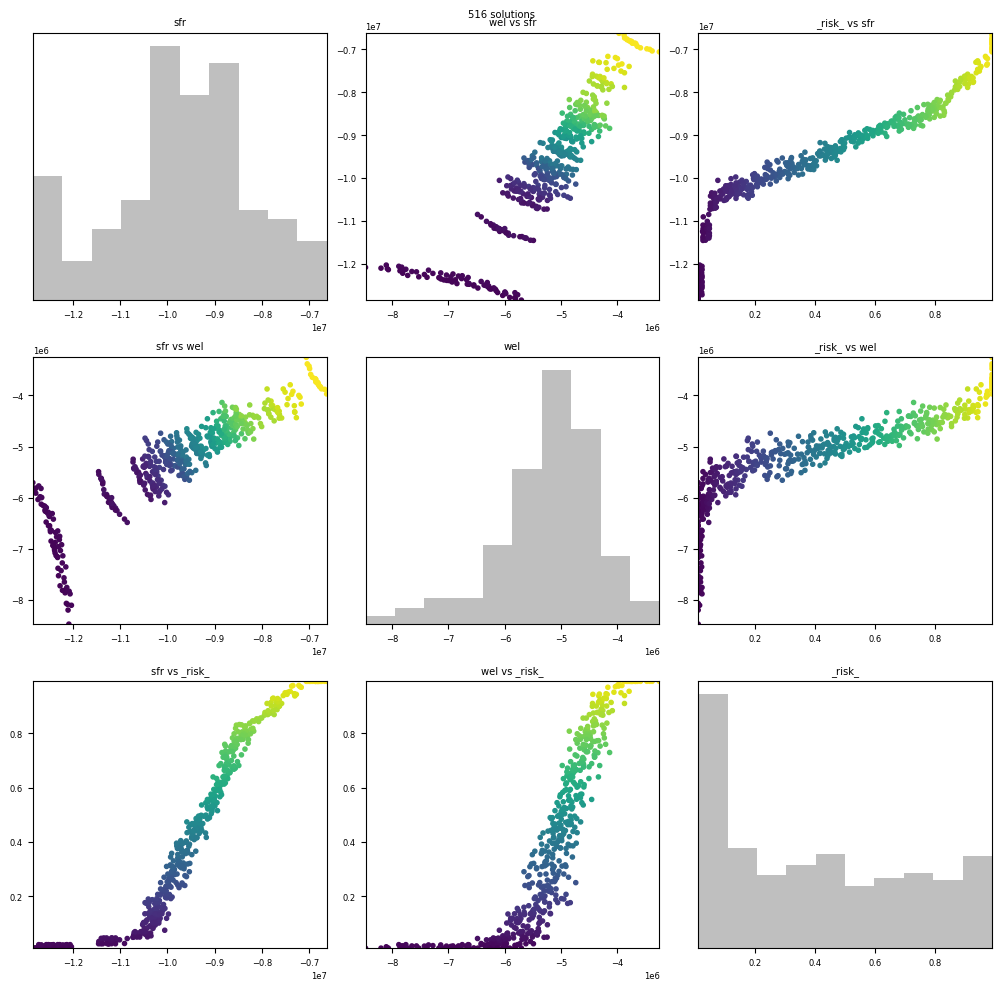

In [26]:
fig,axes = plot_pareto(feas_front_df,feas_front_df.generation.max());
plt.show()

Just take a moment to let that soak in - wow!  So what we see is that the highly reliable solutions (yellow) are clustered around the lower values of water use (duh!) and also are clustered around the lower values of sw-gw exchange volume.  This should be intutive to you, especialy when we remember that all sources of water in to the domain are treated as uncertain.  So this means reliable solutions are going to be coping with less available water. 

How about we focus on highly reliable solutions:

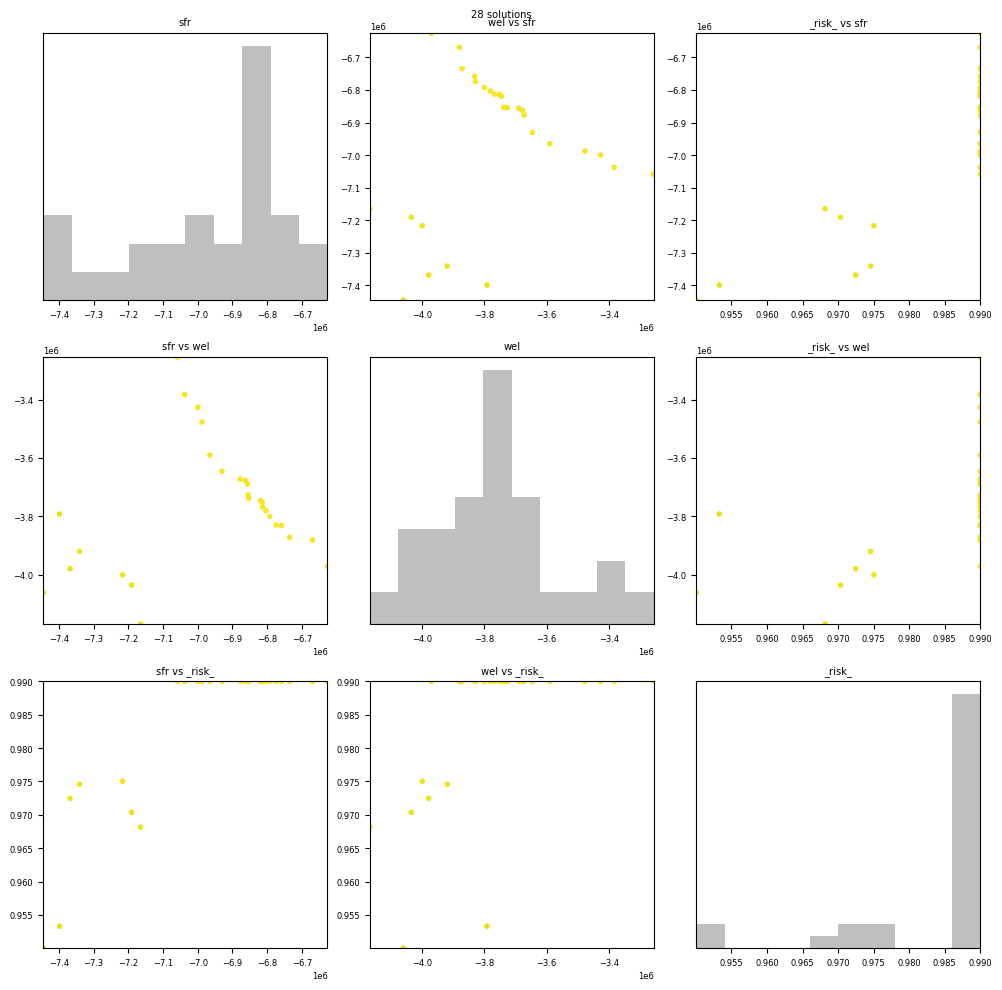

In [27]:
fig,axes = plot_pareto(feas_front_df,feas_front_df.generation.max(),0.95)

plt.show()

If we compare these results to the previous risk-neutral opt (see below also), we see that we are getting a lot __less__ groundwater extraction - this is the cost of uncertainty...if you want to be _certain_ that a "bad thing" won't happen, then you must make do with less.

How about we check the explicitly risk-neutral solutions (with a tolerance around risk = 0.5):

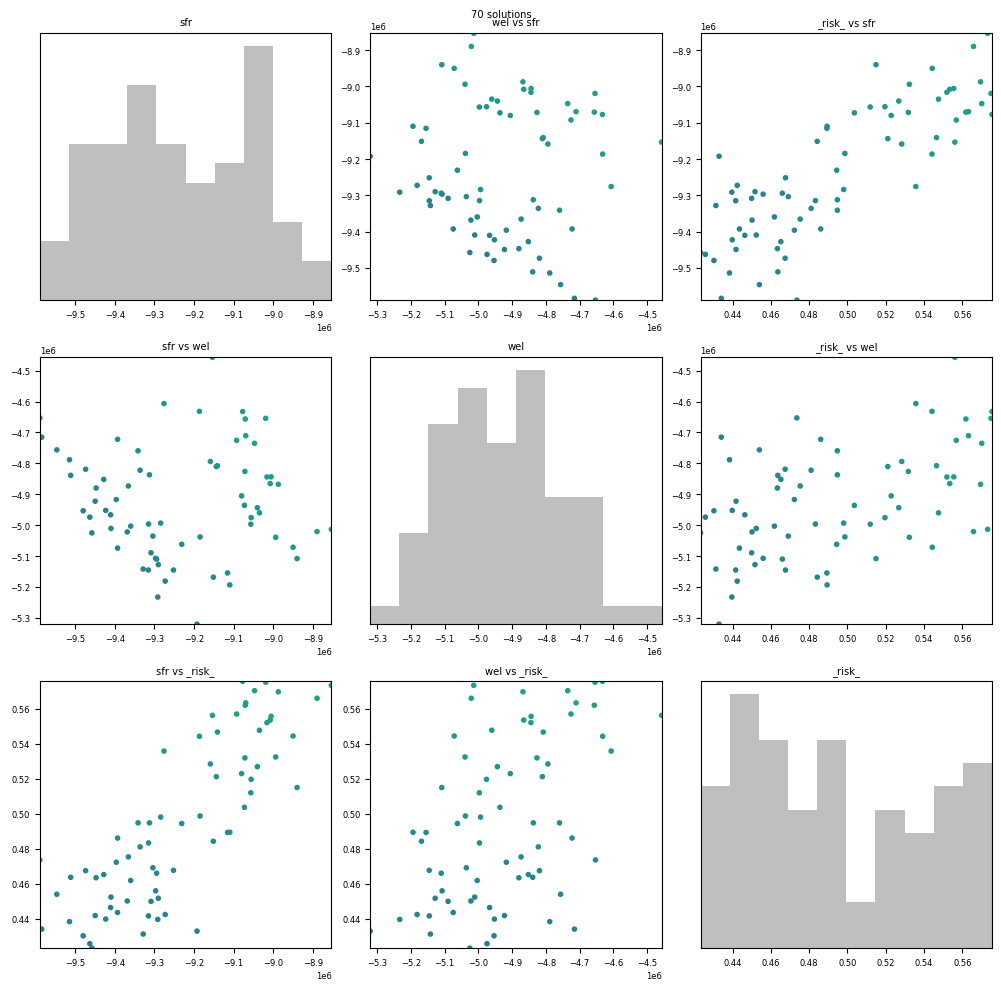

In [28]:
fig,axes = plot_pareto(feas_front_df,feas_front_df.generation.max(),0.42,0.58)
plt.show()

The points are colored the same - make sure you understand where these are on the previous plot...not many solutions, feel free to play with the risk range...

Now let's compare these "risk neutral" solutions with the results from the previous MOU run (which was implicitly risk neutral). Following cells read in the results from the previous MOU tutorial:

In [29]:
# get original results
df_org = pd.read_csv(os.path.join("master_mou_1","freyberg_mf6.pareto.archive.summary.csv"))
# filter for feasibility 
feas_front_df_org = df_org.loc[df_org.apply(lambda x: x.nsga2_front==1 and x.is_feasible==1,axis=1),:]

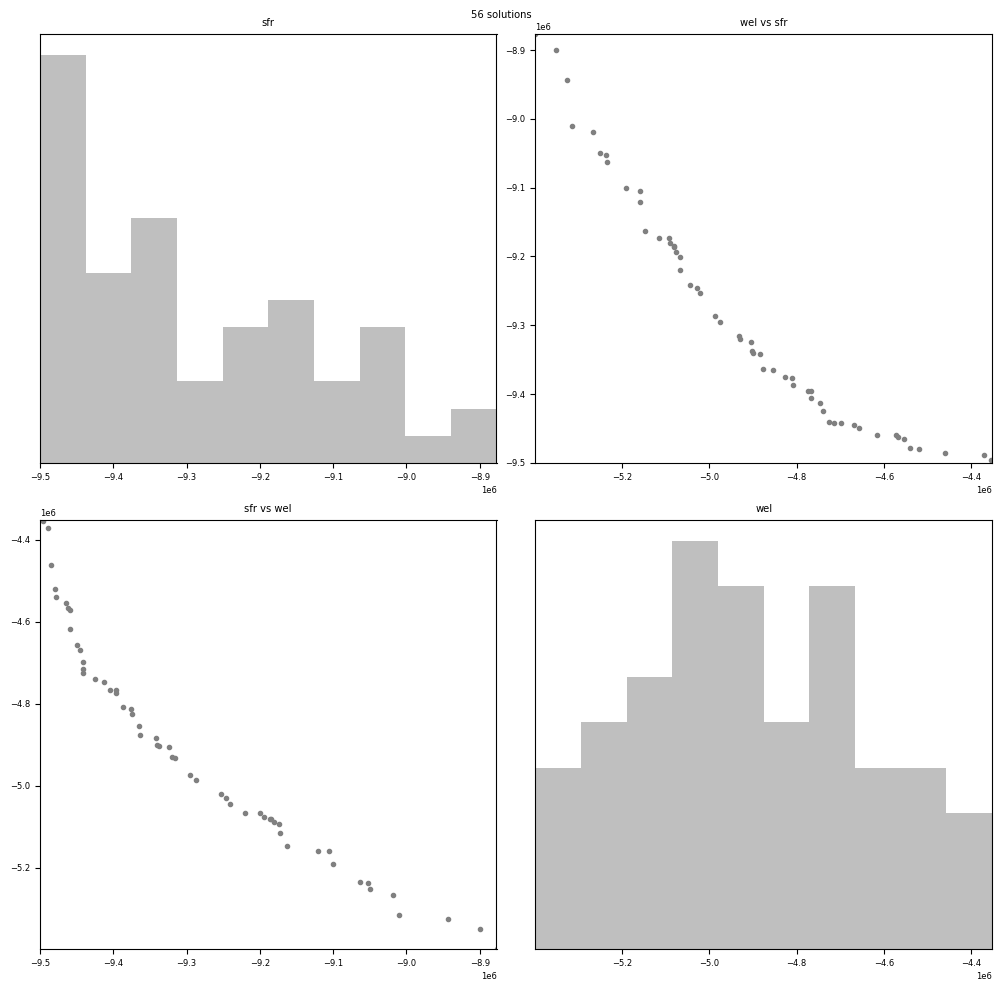

In [30]:
fig,axes = plot_pareto(feas_front_df_org,feas_front_df_org.generation.max(),0.45,0.55);
plt.show()

Ok, so we see that the implicitly risk neutral (first) MOU run found many more solutions along the trade off between water use and sw-gw exchange.  This is because it didnt have the risk objective to deal with.  

This is an important consideration in multi-objective optimization in general:  the __more objectives__ you use, the __harder the algorithm has to work__ and the more generations that will be needed (i.e. more model runs).   But the current MOU run with risk as an objective is clearly in the same range of solutions and (if you squint) you can see that the current run also has the same directionality in the trade off.